# Tutorial: Attention-based de-novo cell-cell communication analysis using RGAST

In this tutorial, we applied RGAST onto the mouse hypothalamic preoptic MERFISH data (slice of Bregma +0.26) and conducted de-novo multi scale CCC analysis.

## Import library

In [2]:
import os,sys
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import warnings
import RGAST
import seaborn as sns
warnings.filterwarnings("ignore")

## Read data

In [3]:
adata = sc.read_h5ad('../data/MERFISH/MERFISH_0.26.h5ad')
dir_output = '.'

In [4]:
adata.obs['cell_type'].value_counts()

cell_type
Inhibitory     1743
OD Mature      1031
Astrocyte       755
Endothelial     518
Excitatory      370
OD Immature     211
Microglia       133
Pericytes        70
Ependymal         1
Name: count, dtype: int64

In [5]:
adata = adata[adata.obs['cell_type'] != 'Ependymal']

OD_list = ['OD Mature','OD Immature']
adata.obs['cell_type'] = adata.obs['cell_type'].astype('str')
adata.obs['cell_type'][adata.obs['cell_type'].isin(OD_list)] = 'Oligodendrocyte'

In [6]:
#preprocess
adata.layers['PCA'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1, exclude_highly_expressed=True,layer='PCA')
sc.pp.scale(adata,layer='PCA')
sc.pp.pca(adata, n_comps=100, layer='PCA')

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

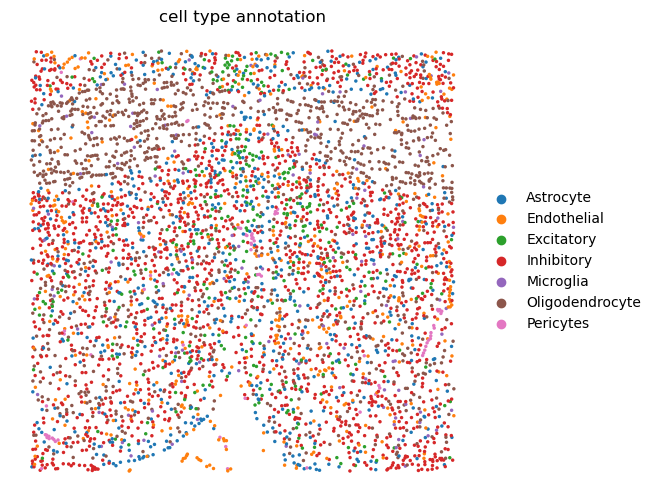

In [7]:
plt.rcParams["figure.figsize"] = (6,6)
sc.pl.embedding(adata, basis="spatial", color="cell_type", show=False)
plt.title("cell type annotation")
plt.axis('off')
plt.show()

## Training

In [8]:
#Constructing the expression and spatial network
RGAST.utils.Cal_Spatial_Net(adata,rad_cutoff=50, model='Radius')
RGAST.utils.Cal_Expression_Net(adata,k_cutoff=3,dim_reduce='PCA')

------Calculating spatial graph...
Spatial graph contains 56608 edges, 4831 cells.
11.7177 neighbors per cell on average.
------Calculating Expression simalarity graph...
Expression graph contains 17474 edges, 4831 cells.
3.6171 neighbors per cell on average.


In [9]:
#Training model
train_RGAST = RGAST.Train_RGAST(adata,center_msg='out',dim_reduction='PCA',device_idx=0)
train_RGAST.train_RGAST(early_stopping=False,n_epochs=200,save_path=dir_output,att_drop = 0.0)

Size of Input:  torch.Size([4831, 100])


100%|██████████| 200/200 [00:09<00:00, 20.15it/s]


In [10]:
# inference
train_RGAST.load_model('model.pth')
_, _, att1, att2 = train_RGAST.process()
adata.uns['att1'] = (att1[0].to('cpu').numpy(),att1[1].to('cpu').numpy())
adata.uns['att2'] = (att2[0].to('cpu').numpy(),att2[1].to('cpu').numpy())

In [11]:
RGAST.cci.attention_to_interact(adata,cum_att_threshold=0.8)
adj = adata.obsp['interact_mat']

## Get LR and pathway information

In [13]:
df_cellchat = RGAST.cci.ligand_receptor_database(species='mouse', signaling_type=None, database='CellChat')

In [14]:
RGAST.cci.analyze_communication_mechanism(adata,df_cellchat,adata.obsp['interact_mat_directed'])


--- Starting Communication Mechanism Analysis ---
Found 16 L-R pairs with all subunits present in the data.


Processing L-R pairs: 100%|██████████| 16/16 [00:05<00:00,  2.67it/s]



Storing aggregated pathway scores...

--- Analysis Finished ---
Scores have been stored in adata.obsp


## Get pathway score

In [15]:
RGAST.cci.calculate_pathway_scores(adata)

--- Calculating pathway scores ---
Successfully calculated scores for 9 pathways.
Scores stored in adata.uns['pathway_score'].


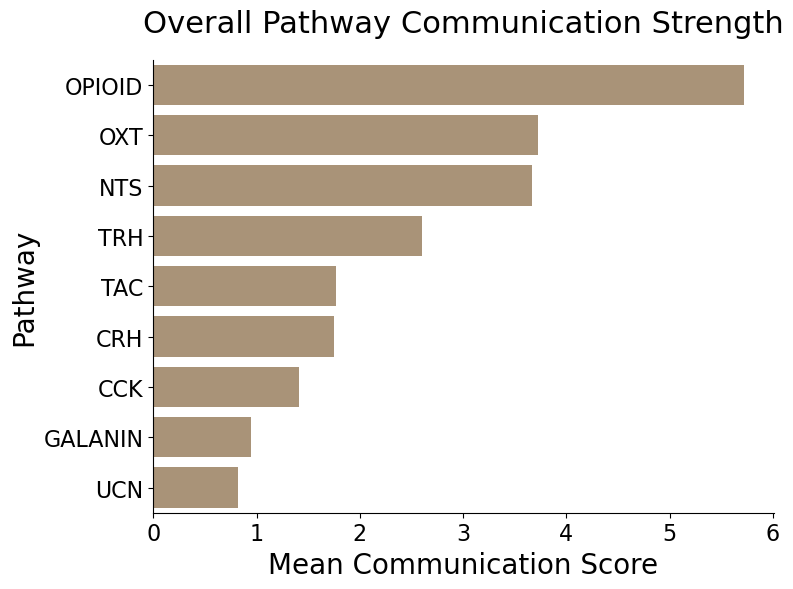

In [16]:
RGAST.cci.plot_pathway_scores(adata)

## Signaling direction analysis

In [17]:
my_cmap = {'Astrocyte': '#1b9e77',
 'Inhibitory': '#d95f02',
 'Oligodendrocyte': '#7570b3',
 'Endothelial': '#e7298a',
 'Pericytes': '#66a61e',
 'Excitatory': '#e6ab02',
 'Microglia': '#a6761d'}

### Overall signaling direction

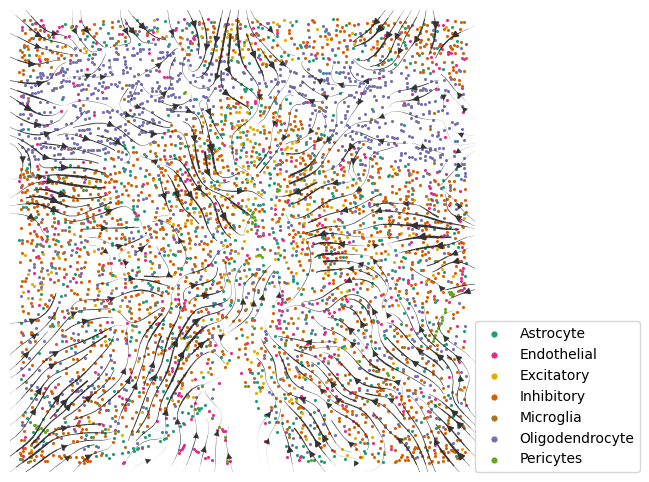

<Axes: >

In [18]:
RGAST.cci.cal_communication_direction(adata)
RGAST.cci.plot_cell_communication(adata,plot_method='stream',background='cluster',clustering='cell_type',cluster_cmap=my_cmap,ndsize=5,background_legend=True,stream_density=2)

### Signaling direction of specific LR pair or pathway

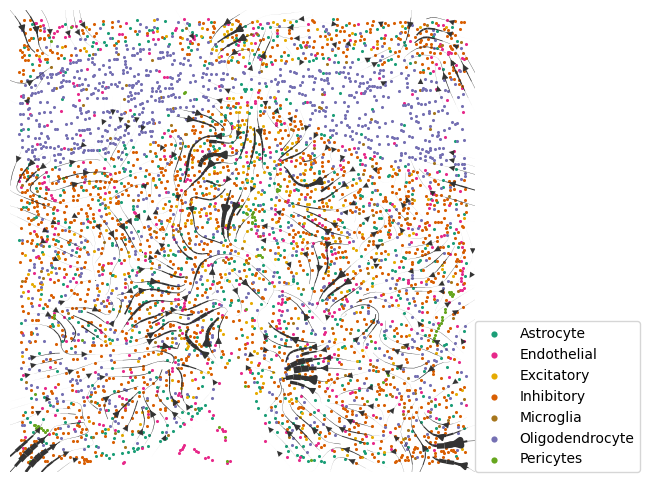

<Axes: >

In [19]:
RGAST.cci.cal_communication_direction(adata,'pathway_OPIOID')
RGAST.cci.plot_cell_communication(adata,plot_method='stream',background='cluster',clustering='cell_type',cluster_cmap=my_cmap,
                                  ndsize=5,background_legend=True,stream_density=2,stream_linewidth= 3)

## Communication between cell groups

#### Overall communication

In [24]:
connectivity = RGAST.cci.calculate_connection_matrix(adata.obsp['interact_mat'],adata.obs['cell_type'])
counts_table = adata.obs['cell_type'].value_counts()

CCC_score = connectivity.copy()
for i in connectivity.index:
    for j in connectivity.columns:
        CCC_score.loc[i,j] = connectivity.loc[i,j]/(counts_table[i]*counts_table[j])

plot_mat_np = CCC_score.to_numpy()
plot_mat_np[np.triu_indices(CCC_score.shape[0],k=0)] = None
plot_mat = pd.DataFrame(plot_mat_np,index=CCC_score.index,columns=CCC_score.columns)
plot_mat = plot_mat.iloc[1:,:-1]

<Axes: >

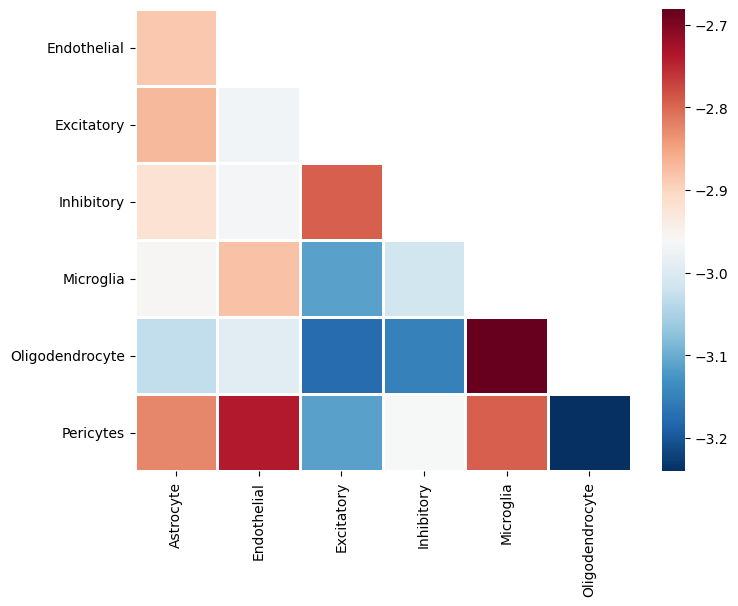

In [25]:
plt.rcParams["figure.figsize"] = (8,6)
sns.heatmap(np.log10(plot_mat), cmap='RdBu_r', linewidths=2)

#### for specific ligand-receptor pair or pathway

In [21]:
connectivity = RGAST.cci.calculate_connection_matrix(adata.obsp['LR_Penk_Oprd1'].toarray(),adata.obs['cell_type']) # for specific ligand-receptor pair
counts_table = adata.obs['cell_type'].value_counts()

CCC_score = connectivity.copy()
for i in connectivity.index:
    for j in connectivity.columns:
        CCC_score.loc[i,j] = connectivity.loc[i,j]/(counts_table[i]*counts_table[j])

plot_mat_np = CCC_score.to_numpy()
np.fill_diagonal(plot_mat_np, None)
plot_mat = pd.DataFrame(plot_mat_np,index=CCC_score.index,columns=CCC_score.columns)

<Axes: >

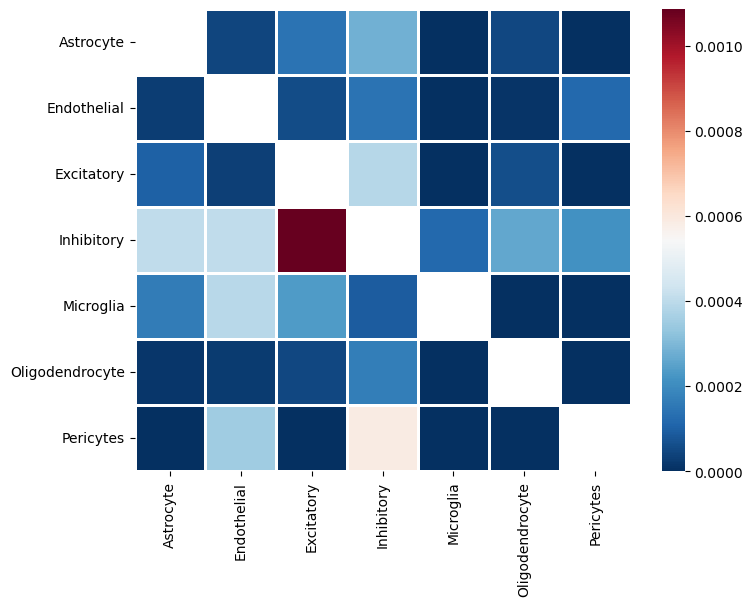

In [23]:
plt.rcParams["figure.figsize"] = (8,6)
sns.heatmap(plot_mat, cmap='RdBu_r', linewidths=2)

## LR interaction between specific cells

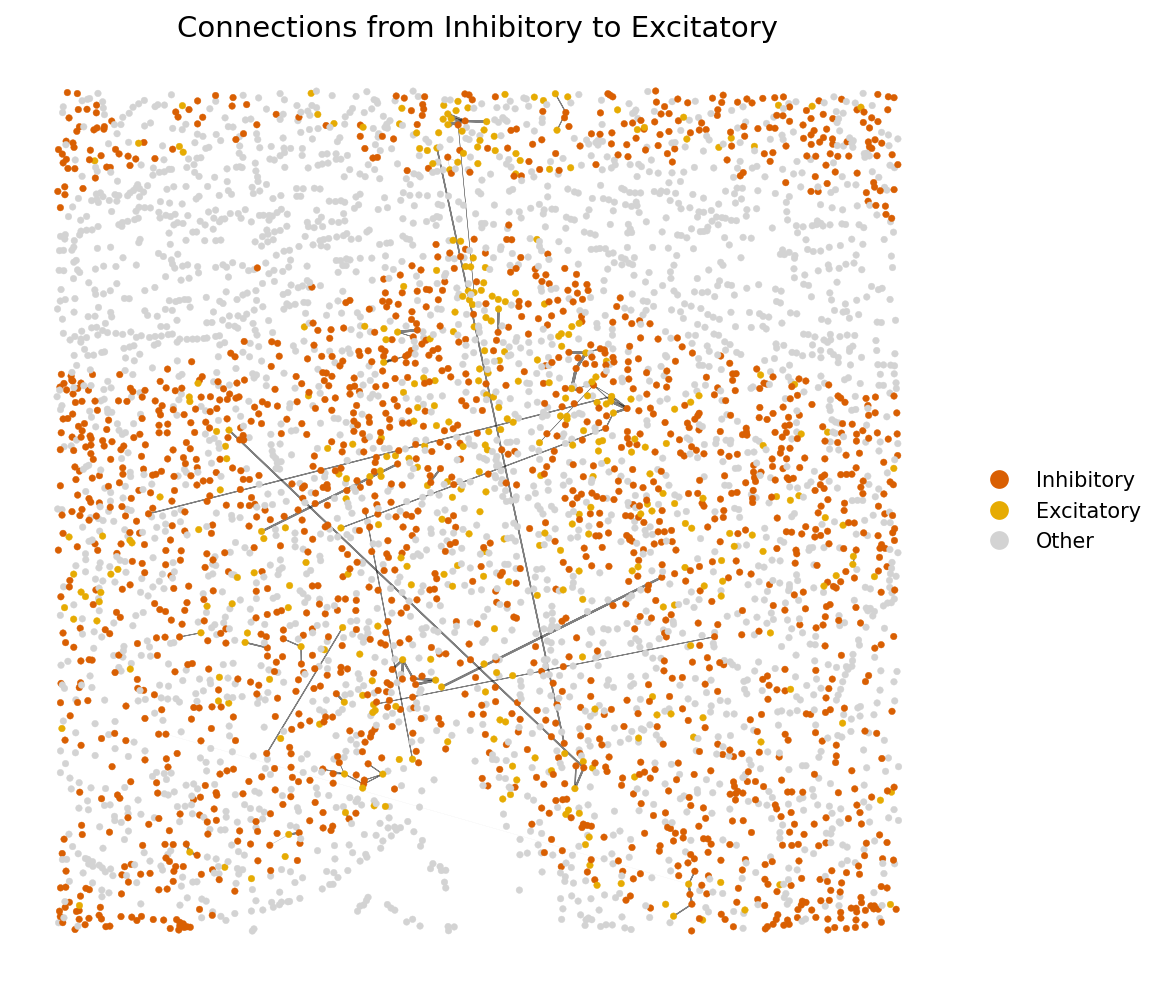

In [26]:
RGAST.cci.plot_cell_connections(adata.obsm['spatial'],adata.obs['cell_type'].astype(str),adata.obsp['LR_Penk_Oprd1'],cell_size=10,
                                directed=True,cmap=my_cmap,sender='Inhibitory', receiver='Excitatory')